In [4]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

In [5]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id,color):
        
        self.dt  = t[1] - t[0]
        self.color = color
        self.r = r0
        self.v = v0
        self.a = a0
        self.f = np.array([0.,0.])        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        self.kVector= np.zeros(len(t))
        self.epVector = np.zeros( len(t) )
        self.m = m
        self.radius = radius
        self.Id = Id
        self.Ep=0
        self.k=0.5*self.m*np.linalg.norm(self.v)**2
        
    # Method
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.epVector[i]=self.Ep
        self.kVector[i]=self.k
        # Euler method     
        self.a = self.f
        self.r +=self.dt*self.v
        self.v += self.dt * self.a
        self.f=0
        self.Ep=0
        self.k=0.5*self.m*np.linalg.norm(self.v)**2
          
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
    
    def CheckColition(self, particles):
        for i in range(len(particles)):
            distance=np.linalg.norm(self.r-particles[i].GetPosition())
            compression= self.radius +particles[i].GetR() -distance
            if self.Id != i:
                if compression>0:
                    Fn=100.*(compression**3)/distance
                    self.f=np.add(self.f,Fn*(self.r-particles[i].GetPosition()))
                    self.Ep+=100.*compression**4 /4.
                               
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    def GetPosition(self):
        return self.r

    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    

    def GetVelocityVector(self):
        return self.vVector
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.rVector[0]]) # initial condition
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                


In [6]:
dt = 1*10**(-4)
tmax = 10
t = np.arange(0,tmax+dt,dt)

In [7]:
def GetParticles(NParticles,Limit,Posi,Velo,Id,color,radio=2.,Dim=2,dt=1*10**(-4)):

        
    x0 = Posi
    v0 = Velo
    a0 = np.zeros(Dim)

    p = Particle(x0,v0,a0,t,1.,radio,Id,color)
        

        
    return p

In [8]:
Limits = np.array([20.,20.])


In [9]:
def RunSimulation(t):

    Particle1 = GetParticles(1,Limits[0],Posi=np.array([-10.,0.]),Velo = np.array([20.,0.]),dt=dt,Id=0,color="yellow")
    Particle2 = GetParticles(1,Limits[0],Posi=np.array([0.,-1.6]),Velo = np.array([0,0.]),dt=dt,Id=1,color="red")
    Particle3 = GetParticles(1,Limits[0],Posi=np.array([-15.,-15.]),Velo = np.array([0.,0.]),dt=dt,Id=2,color="black")
    Particles=np.array([Particle1,Particle2,Particle3])
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):
            Particles[i].CheckColition(Particles)
            Particles[i].CheckWallLimits(Limits)
            Particles[i].Evolution(it)
        
        
    return Particles

In [10]:
Particles = RunSimulation(t)

100%|██████████| 100001/100001 [00:19<00:00, 5038.61it/s]


In [11]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [12]:
redt = ReduceTime(t,1000)
len(Particles[0].GetRPositionVector())

101

<IPython.core.display.Javascript object>


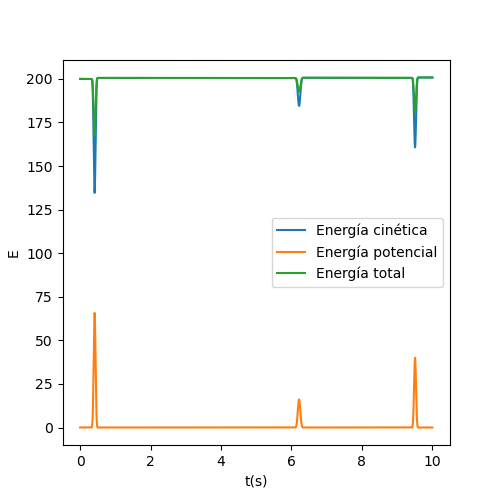

In [17]:
KineticEnergy=Particles[0].kVector+Particles[1].kVector+Particles[2].kVector
PotentialEnergy=(Particles[0].epVector+Particles[1].epVector+Particles[2].epVector)/2

MechanicalEnergy=KineticEnergy+PotentialEnergy/2
fig1= plt.figure(figsize=(5,5))
plt.plot(t,KineticEnergy,label="Energía cinética")
plt.plot(t,PotentialEnergy,label="Energía potencial")
plt.plot(t,MechanicalEnergy,label="Energía total")
plt.xlabel("t(s)")
plt.ylabel("E")
plt.legend()
plt.savefig("EJ1_energia del sistema")

<IPython.core.display.Javascript object>


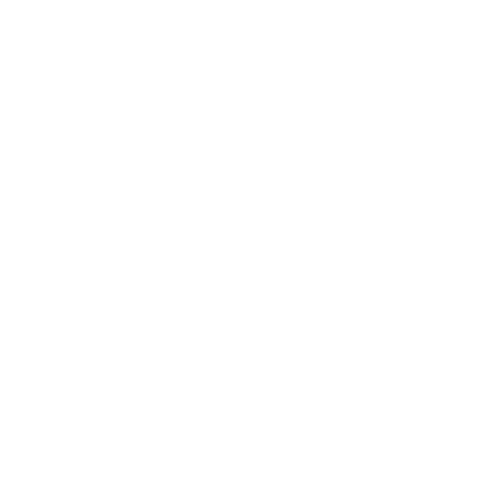

In [44]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]

        
        circle = plt.Circle( (x,y), p.GetR(),color=p.color, fill=True)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        plot = ax.add_patch(circle)
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

In [12]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=30, metadata=dict(artist='Me'))
Animation.save('billar.mp4', writer=writer_)